In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
import itertools
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.losses import MSLE, MeanAbsolutePercentageError
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.constraints import non_neg
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_log_error, make_scorer
from sklearn.linear_model import Ridge
warnings.resetwarnings()
warnings.simplefilter(action='ignore', category=DeprecationWarning)


# CNN COVID-19 case number forecasting.


# COVID-19 prediction using a convolutional neural network

## Table of contents
<a id='toc'></a>
## [1. Introduction](#intro)
## [2. Data](#data)
## [3. Convolutional Neural Network](#model)
## [4. Analysis](#analysis)
## [5. Conclusion and Future Work](#conclusion)

<a id='intro'></a>
# 1. Introduction 
[Return to table of contents](#toc)
The main purpose of this notebook is to tune the hyperparameters and architecture of a simple one dimensional convolutional neural network such that it is able to make accurate predictions of the number of new cases. In pursuit of this goal, I elect to utilize the keras API for the deep learning implementation. The details or philosophy on how the model is constructed is also detailed in the model prototypes notebook, this notebook is simply devoted to tuning the model parameters; the architecture could also be played with (and has been) but I will leave any dramatically different architectures to different notebooks. The current architecture in this notebook represents the best (using the performance from the prototyping stage as a metric). 

Other inclusions which were previously tested were: more activation layers, pooling layers, dropout layers, non negative kernel constraints (the predicted value should be non-negative, there is a constraint for this). The architecture that is fixed in this notebook consists of two convolutional layers followed by two fully connected layers. In the first convolutional layer, the number of filters is chosen to be much larger than the filters in the second convolutional layer (but is also tuned). Likewise, the output of the first fully connected layer is much larger than the second (which has only 1 output in this setup). To ensure that all future tests are comparable, I always start with the same model coefficients by initializing the kernels of each layer of the network. This introduces even more parameters, using a normal distribution to initialize, such as the mean and standard deviation. This is not an issue however as in the final model these kernel initializers will be unincluded. The data is split such that the final holdout set contains a single day's information, the validation set contains 1 week or 7 days of information and the remainder is in the training set.


# Function Declarations

In [2]:

#################  Helper functions for debugging, mainly #################
def country_slice(data, locations):
    """ simply a helper function to cut down on verbosity, slices location column"""
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    """ simply a helper function to cut down on verbosity, slices time index"""
    if start < 0 and end < 0:
        if start == -1:
            start = data.loc[:, indexer].max()
        else:
            start = data.loc[:, indexer].max()+start
        if end == -1:
            end = data.loc[:, indexer].max()
        else:
            end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]

def column_search(df, name, return_style='loc', threshold='contains'):
    """ Utility for slicing columns with partial and exact matching"""
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None

def residual_plot(y_test, y_predict, title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_test, y_test-y_predict.ravel(), s=5)
    ax.set_ylabel('Residual')
    ax.set_xlabel('True value')
    ax.grid(True)
    return None

def create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries):
    for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
        # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
        frame_data = model_data[(time_index <= max_date_in_window-1) & 
                                (time_index >= max_date_in_window-frame_size)]
        # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
        reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)

        # *********************** WARNING: pad_sequences converts to integers by default *********************
        resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
        frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
        if max_date_in_window == start_date:
            print('Starting with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
            X = frame_data_4D.copy()
        else:
            X = np.concatenate((X, frame_data_4D),axis=0)
    print('Ending with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
    y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
    return X, y

def split_Xy(X, y, frame_size, n_validation_frames, n_test_frames, train_test_only=False, model_type='cnn'):
    """ Split into training, validation and test data.
    """
    # the indices for the train-validate-test splits for when the predictors are put in a 2-d format.
    train_indices = list(range(n_countries*0, n_countries*(len(X)-(n_validation_frames+n_test_frames))))
    validate_indices = list(range(n_countries*(len(X)-(n_validation_frames+n_test_frames)), n_countries*(len(X)-n_test_frames)))
    test_indices = list(range(n_countries*(len(X)-n_test_frames), n_countries*len(X)))
    indices = (train_indices, validate_indices, test_indices)

    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        X_train= X[:-n_test_frames,:,:,:]
        y_train =  y[:-n_test_frames,:]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_test, y_test)
    else:
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_validate, y_validate,
                   X_test, y_test)

    return splits, indices


def model_analysis(y_true, y_naive, y_predict, n_countries, title='',suptitle='', 
                   figname=None, scale=None, s=None, model_params=None):
    print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
    #     y_predict[y_predict<0]=0
    # compute scores 
    MSLE_naive = mean_squared_log_error(y_true.ravel(), y_naive.ravel())
    MSLE_predict = mean_squared_log_error(y_true.ravel(), y_predict)
    r2_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
    r2_predict = explained_variance_score(y_true.ravel(), y_predict)

    print('{}-step MSLE [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, MSLE_naive, MSLE_predict))
    print('{}-step R^2 [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, r2_naive, r2_predict))

    fig, axes = plt.subplots(2, 2, figsize=(15,10))
    (ax1,ax2,ax3,ax4) = axes.flatten()
    if scale == 'log':
        ymax = np.max([np.log(1+y_true).max(), np.log(1+y_predict).max()])
        ax1.scatter(np.log(y_true+1), np.log(y_naive+1), s=s,alpha=0.7)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(np.log(y_true+1), np.log(y_predict+1), s=s,alpha=0.7)
        ax2.plot([0, ymax], [0, ymax],color='r')
    else:
        ymax = np.max([y_true.max(), y_predict.max()])
        ax1.scatter(y_true, y_naive, s=s)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(y_true, y_predict, s=s)
        ax2.plot([0, ymax], [0, ymax],color='r')
    
    ax1.text(0.0, ymax,'$MSLE$ = {}'.format(np.round(MSLE_naive,3)),fontsize=14)
    ax1.text(0.0, 0.9*ymax,'$R^2$ = {}'.format(np.round(r2_naive,3)),fontsize=14)
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title('Naive model')
             
    ax2.text(0.0, ymax,'$MSLE$ = {}'.format(np.round(MSLE_predict,3)),fontsize=14)
    ax2.text(0.0, 0.9*ymax,'$R^2$ = {}'.format(np.round(r2_predict,3)),fontsize=14)
    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(title)
    ax1.grid(True)
    ax2.grid(True)
    plt.suptitle(suptitle)

    
    xrange = range(len(y_true))
    if scale=='log':
        residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax3)
        residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax4)
    else:
        residual_plot(y_true,y_naive, ax=ax3)
        residual_plot(y_true,y_predict, ax=ax4)
    ax3.set_title('')
    ax4.set_title('')
    ax3.set_ylabel('Residual')
    ax4.set_ylabel('Residual')
    ax3.grid(True)
    ax4.grid(True)
    
    if figname is not None:
        plt.savefig(figname, bbox_inches='tight')
        
    if model_params is not None:
        param_labels = ['epochs = ', 'batch_size = ', 'filter_1 = ', 'filter_2 = ', 
                        'kernel_size_1 = ', 'kernel_size_2 = ', 'first_dense_layer_output_dimension = ']
        label_value_pairs = [param_labels[i] + str(model_params[i]) for i in range(len(model_params))]
        plt.text(0.0, 1.15, ', '.join(label_value_pairs), transform=ax1.transAxes)
    plt.show()
    return None

def normalize_Xy(splits, feature_range=(0., 1.0), normalization_method='minmax',
                        train_test_only=False, feature_indices=None):
    """ Split into training, validation and test data.
    
    
    Notes
    -----
    Normalize with respect to some arbitrary absolute max, just choose 2*absolute max of training set. 
    The function is so long because the different shapes of the different ps
    """
    
    min_, max_ = feature_range
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    feature_minima = X_train[:,:,:,:].min((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_maxima = 2*X_train[:,:,:,:].max((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_denominator = feature_maxima-feature_minima
    # get the shape of each split's array, so that array arithmetic can be done. 
    train_tile_shape = np.array(np.array(X_train.shape)/np.array(feature_maxima.shape),int)
    validate_tile_shape = np.array(np.array(X_validate.shape)/np.array(feature_maxima.shape),int)
    test_tile_shape = np.array(np.array(X_test.shape)/np.array(feature_maxima.shape),int)

    # using X - X_min / (X_max-X_min). Form denominator
    train_denominator = np.tile(feature_denominator, train_tile_shape)
    validate_denominator = np.tile(feature_denominator, validate_tile_shape)
    test_denominator = np.tile(feature_denominator, test_tile_shape)
    
    # and then the minima.
    train_minima = np.tile(feature_minima,train_tile_shape)
    validate_minima = np.tile(feature_minima,validate_tile_shape)
    test_minima = np.tile(feature_minima,test_tile_shape)
    
    # factor of 1/max_ accounts for absolute maximum that is outside of the data (i.e. potential future values). 
    X_train_scaled = (max_-min_)*(X_train - train_minima)/train_denominator
    X_validate_scaled = (max_-min_)*(X_validate - validate_minima)/validate_denominator
    X_test_scaled = (max_-min_)*(X_test - test_minima)/test_denominator

    
    scaled_splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test) 
    scaling_arrays =  (feature_maxima, feature_minima, feature_denominator)

    return scaled_splits, scaling_arrays

def concatenate_4d_into_3d(splits, train_test_only=False):
    
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_validate = np.concatenate(X_validate, axis=0)
        y_validate = np.concatenate(y_validate, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return concat_splits

# 2. Data processing
<a id='data'></a>
[Return to table of contents](#toc)

The main format (shape) of the data and how it is being sliced and then reshaped is described in the notebook ```COVID19_model_prototypes.ipynb``` and so I will avoid a redundant discussion here. 

In regards to the feature data being considered, I am using the time series corresponding to new cases per million, its logarithm, the OxCGRT "government response index" which scores each goverments reaction with a number from 0 to 100. 
There are some features which at first seem relevant but I am not using due to the fact that they are time-delayed with respect to new cases, for example, deaths and recoveries of course occur a case is confirmed by definition. I am in fact not using the data on the number of tests either because the feature lacks a consistent set of units; this would mean that the feature would need to be split into multiple features, one for each unit. 

In [3]:
data = pd.read_csv('../data/model_data.csv', index_col=0)

Probably the biggest gap in this project is the lack of a quantitative feature selection; I instead utilized a qualitative approach and numerical experimentation.  

In [4]:
print('There are {} different countries included in the data'.format(data.location.nunique()))
print('The time series span {} different days'.format(data.time_index.nunique()))

There are 146 different countries included in the data
The time series span 183 different days


As a reminder, the data format as well as the features being included are both described in the model prototyping notebook. The most obvious parameters with which to tune the model are the number of training epochs, the batch size of the training, the number of filters in each convolutional layer, the size of the convolutional kernel (i.e. convolutional window) and finally the number of outputs in the first dense layer. Something to keep in mind as well is that the data I am training with contains only 20000 samples, and so I believe the parameters should not be too large.

    epochs : Number of training epochs. 
    batch_size : number of samples used in each gradient update 
    filter1 : number of filters,  first convolutional layer
    kernel1_size : kernel size, first convolutional layer
    filter2 : number of filters,  second convolutional layer
    kernel2_size : kernel size, second convolutional layer
    first_dense_layer_output_dimension : number of nodes in hidden fully connected layer


In [5]:
modeling_features = ['new_cases_per_million', 'government_response_index', 'log_new_cases_per_million']
model_data = data.copy().loc[:, modeling_features]
new_cases_index = column_search(model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
n_countries = data.location.nunique()
target_data = data.new_cases_per_million
time_index = data.time_index

frame_size = 28
start_date = frame_size + data.time_index.min()

n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

Create, split, and scale the data into tensors which will abide by keras conventions (after collapsing the first axis, at least)

In [6]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)

scaled_splits, scaling_arrays =  normalize_Xy(splits, feature_range=(0,1.0), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)
# if need to supply folds for sklearn CV regression functions.
(X_cnn_train, y_cnn_train, X_cnn_validate, y_cnn_validate, X_cnn_test, y_cnn_test) = scaled_splits
(train_indices, validate_indices, test_indices) = indices

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 154 181


In [7]:
print(X.shape)
print('There are a total of {} frames'.format(X.shape[0]))
print('There are a total of {} countries'.format(X.shape[1]))
print('There are a total of {} time steps in each frame'.format(X.shape[2]))
print('There are a total of {} features'.format(X.shape[3]))

(155, 146, 28, 3)
There are a total of 155 frames
There are a total of 146 countries
There are a total of 28 time steps in each frame
There are a total of 3 features


After the data is split with respect to time, the axis corresponding to time is collapsed such that the 
"batch" (keras notation) axis now contains all frames for all countries.

In [8]:
splits_3d = concatenate_4d_into_3d(scaled_splits)
(X_cnn_train_model, y_cnn_train_model, X_cnn_validate_model,
 y_cnn_validate_model, X_cnn_test_model, y_cnn_test_model) = splits_3d

Instantiate the naive baseline values for comparison.

In [9]:
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index].ravel()
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index].ravel()
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index].ravel()

Combinations of hyperparameters with which to tune the model with.
**Note this does not exhaust all combinations that I have tried, which is represented by the score logging .csv**

In [10]:
epochs_list = [50,75,100,125,150]
# use a larger batch size for cross validation to speed it up
batch_size_list = [1024]
filter1_list = [16]
filter2_list = [4]
kernel1_size_list = [8]
kernel2_size_list = [8]
# need to keep the number of parameters down, used to be way too many parameters. 
# With these kernel sizes, the dimension of the input to first dense layer is 56
first_dense_layer_output_dimension_list = [4, 8, 32, 64, 128]

Combine the parameter lists into combinations using itertools.

In [11]:
parameter_combinations = list(itertools.product(epochs_list, batch_size_list, filter1_list,
                                                filter2_list, kernel1_size_list, kernel2_size_list,
                                                first_dense_layer_output_dimension_list))

In order to both save the results as well as ensure that the run of this notebook can be broken up into sessions, create a DataFrame which logs the scores and saves them to a .csv file. During the exploration of hyperparameters, I elected to log the scores, but I did it  The scores that are saved are the ones generated by the validation set predictions. Also included for comparison purposes are the scores resulting from the naive baseline. 

In [12]:
save_filename = '../data/cnn_score_logging.csv'
if not os.path.isfile(save_filename):
    new_score_df = pd.DataFrame(np.array(parameter_combinations), 
                                    columns=['epochs','batch_size','filter_1',
                                             'filter_2','kernel_1','kernel_2',
                                             'first_dense_layer_output_dimension'])
    new_score_df.loc[:, 'mean_squared_log_error'] = np.nan
    new_score_df.loc[:, 'explained_variance'] = np.nan
    new_score_df.loc[:, 'naive_explained_variance'] = np.nan
    new_score_df.loc[:, 'naive_mean_squared_log_error'] = np.nan

    if os.path.isfile(save_filename):
        all_scores = pd.concat((pd.read_csv(save_filename,
                                            index_col=0), new_score_df),axis=0).reset_index(drop=True)
    else:
        all_scores = new_score_df.reset_index(drop=True)


    # remove any duplicate parameter combinations, as the same seeds are being used. 
    no_duplicates_index = all_scores.iloc[:, :7].drop_duplicates().index
    all_scores = all_scores.loc[no_duplicates_index,:]
else:
    all_scores = pd.read_csv('../data/cnn_score_logging.csv', index_col=0)

<a id='model'></a>
# 3. Convolutional neural network model 
[Return to table of contents](#toc)

First, a description of the convolutional neural network architecture used in this notebook. 
The convolution is with respect to time, specifically the time steps within the 'time frames' described in the prototyping notebook. The architecture is comprised of two convolutional layers followed by two dense layers, ending with a ReLU activation layer. The hyperparameters to be tuned include the filter number for both convolutional layers, their kernel sizes (convolutional window), the number of epochs, batch_size, and the output dimension of the first dense layer. The goal for the convolutional neural network is to learn the patterns which occur in the time series and then have the dense layers predict via their combinations, at least this is how I think of it. Similar to the fully connected neural network, I believe it is important to have a number of parameters smaller than the number of samples for learning purposes. 

I use static seeds to ensure that the cross-validation process is reproducible. I iterate over three combinations of seeds, defined by their positional index. 

In [13]:
zero_seeds = [0,1,2]
one_seeds = [3,4,5]
two_seeds = [6,7,8]
three_seeds = [9,10,11]

Iterate over the yet to be scored parameter combinations, fitting the model and recorded the scores. 

In [14]:
for i in all_scores[all_scores.mean_squared_log_error.isna()].index:
    
    MSLE_list = []
    naive_MSLE_list = []
    explained_variance_list = []
    naive_explained_variance_list = []
    mae_list = []
    naive_mae_list = []
    
    hyperparameters = all_scores.loc[i, :].iloc[:7].astype(int).values
    (epochs, batch_size, filter1, 
     filter2, kernel1_size, kernel2_size, first_dense_layer_output_dimension) = hyperparameters
    
    for j in range(len(zero_seeds)):
        cnn = Sequential()
        cnn.add(Conv1D(filters=int(filter1), kernel_size=int(kernel1_size),
                         padding='valid',
                         input_shape=X_cnn_train.shape[2:],
                         use_bias=False,
                        kernel_initializer=RandomNormal(seed=zero_seeds[j])
                        )
                 )
        cnn.add(Conv1D(filters=int(filter2), 
                         kernel_size=int(kernel2_size), 
                         padding='valid',
                         use_bias=False,
                        kernel_initializer=RandomNormal(seed=one_seeds[j])
                        )
                 )
        cnn.add(Flatten())
        cnn.add(Dense(first_dense_layer_output_dimension, 
                      kernel_initializer=RandomNormal(seed=two_seeds[j])
                       )
                 )
        cnn.add(Dense(1, 
                        activation='relu',
                      kernel_initializer=RandomNormal(seed=three_seeds[j])
                           ))
        cnn.compile(loss='mean_squared_logarithmic_error',
                    optimizer='adam')
        history = cnn.fit(X_cnn_train_model, y_cnn_train_model, epochs=epochs, validation_data=(X_cnn_validate_model, y_cnn_validate_model), 
                  batch_size=batch_size, verbose=0)

        y_true = y_cnn_validate_model.ravel()
        y_predict = cnn.predict(X_cnn_validate_model).ravel()
        y_naive = y_validate_naive.ravel()

        # naive MSLE, r2, mae
        naive_MSLE_list.append(mean_squared_log_error(y_true.ravel(), y_naive.ravel()))
        naive_explained_variance_list.append(explained_variance_score(y_true.ravel(), y_naive.ravel()))
        naive_mae_list.append(mean_absolute_error(y_true.ravel(), y_naive.ravel()))

        # MSLE, r2, mae
        MSLE_list.append(mean_squared_log_error(y_true.ravel(), y_predict))
        explained_variance_list.append(explained_variance_score(y_true.ravel(), y_predict))
        mae_list.append(mean_absolute_error(y_true.ravel(), y_predict))

    # add the scores
    all_scores.loc[i,'naive_mean_squared_log_error'] =  np.mean(naive_MSLE_list)
    all_scores.loc[i,'mean_squared_log_error']  = np.mean(MSLE_list)
    all_scores.loc[i,'naive_explained_variance']  = np.mean(naive_explained_variance_list)
    all_scores.loc[i,'explained_variance']  = np.mean(explained_variance_list)
    # every time a new score is calculated, overwrite the original file to log scoring.
    all_scores.to_csv(save_filename)

    print('#',end='')
    if (i % 50 == 0) & (i>0):
          print(' {} runs completed'.format(str(i)))



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
#########################

A quick look at the different results (mean squared error of predictions on validation set

In [15]:
all_scores.sort_values(by='mean_squared_log_error').head(10)

,epochs,batch_size,filter_1,filter_2,kernel_1,kernel_2,first_dense_layer_output_dimension,mean_squared_log_error,explained_variance,naive_explained_variance,naive_mean_squared_log_error
24,150,1024,16,4,8,8,128,0.150145,0.929805,0.926058,0.196325
23,150,1024,16,4,8,8,64,0.153875,0.925083,0.926058,0.196325
19,125,1024,16,4,8,8,128,0.157209,0.923605,0.926058,0.196325
22,150,1024,16,4,8,8,32,0.158439,0.921345,0.926058,0.196325
18,125,1024,16,4,8,8,64,0.160835,0.918951,0.926058,0.196325
14,100,1024,16,4,8,8,128,0.164984,0.919771,0.926058,0.196325
17,125,1024,16,4,8,8,32,0.166308,0.918137,0.926058,0.196325
13,100,1024,16,4,8,8,64,0.171056,0.916069,0.926058,0.196325
21,150,1024,16,4,8,8,8,0.171847,0.916649,0.926058,0.196325
9,75,1024,16,4,8,8,128,0.176368,0.914125,0.926058,0.196325


Use these "best" model parameters with random kernels instead of the seeded ones.

In [16]:
best_model_parameters = all_scores.loc[all_scores.mean_squared_log_error.idxmin(),:].iloc[:7]
best_model_parameters.astype(int)

epochs                                 150
batch_size                            1024
filter_1                                16
filter_2                                 4
kernel_1                                 8
kernel_2                                 8
first_dense_layer_output_dimension     128
Name: 24, dtype: int32

The static seeds for the ultimate model.

In [17]:
kernel5 = RandomNormal(seed=5)
kernel6 = RandomNormal(seed=6)
kernel7 = RandomNormal(seed=7)
kernel8 = RandomNormal(seed=8)

Now that parameters have been tuned, can use both the validation and training sets for training, and then predict on the final hold-out, testing set.

In [18]:
X_final_train = np.concatenate((X_cnn_train_model, X_cnn_validate_model),axis=0)
y_final_train = np.concatenate((y_cnn_train_model, y_cnn_validate_model),axis=0)

Compile and preview the final model to ensure the parameter number isn't too large. 

In [19]:
best_model_parameters= best_model_parameters.astype(int).values
(epochs, batch_size, filter1, 
 filter2, kernel1_size, kernel2_size,first_layer_output_dimension) = best_model_parameters
best_cnn = Sequential()
best_cnn.add(Conv1D(filters=int(filter1), kernel_size=int(kernel1_size),
                 padding='valid',
                 input_shape=X_cnn_train.shape[2:],
                 use_bias=False,
                kernel_initializer=kernel5,
                )
         )
best_cnn.add(Conv1D(filters=int(filter2), 
                 kernel_size=int(kernel2_size), 
                 padding='valid',
                 use_bias=False,
                kernel_initializer=kernel6,
                )
         )
best_cnn.add(Flatten())
best_cnn.add(Dense(first_layer_output_dimension,
                kernel_initializer=kernel7,
               )
         )
best_cnn.add(Dense(1, 
                activation='relu',  
                kernel_initializer=kernel8,
                   ))
best_cnn.compile(loss='mean_squared_logarithmic_error', optimizer=Adam())
best_cnn.summary()

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_150 (Conv1D)          (None, 21, 16)            384       
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 14, 4)             512       
_________________________________________________________________
flatten_75 (Flatten)         (None, 56)                0         
_________________________________________________________________
dense_150 (Dense)            (None, 128)               7296      
_________________________________________________________________
dense_151 (Dense)            (None, 1)                 129       
Total params: 8,321
Trainable params: 8,321
Non-trainable params: 0
_________________________________________________________________


Look at the final set of weights to see if anything unusual occurred; i.e. very large weights. 

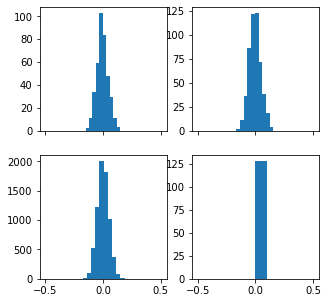

In [20]:
fig, axes = plt.subplots(2,2, figsize=(5,5),sharex=True)
(ax1,ax2,ax3,ax4) = axes.flatten()
_ = ax1.hist(best_cnn.get_weights()[0].ravel())
_ = ax2.hist(best_cnn.get_weights()[1].ravel())
_ = ax3.hist(best_cnn.get_weights()[2].ravel())
_ = ax4.hist(best_cnn.get_weights()[3].ravel())
plt.show()

Train the final model.

In [21]:
history = best_cnn.fit(X_final_train, y_final_train, epochs=epochs, validation_data=(X_cnn_test_model, y_cnn_test_model), 
          batch_size=batch_size, verbose=0)

<a id='analysis'></a>
# 4. Analysis
[Return to table of contents](#toc)

To ensure that we are not overtraining the final CNN model, let's look at the plots of validation loss and training loss as a function of the number of epochs.

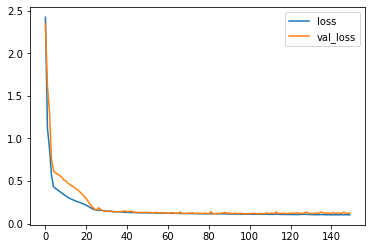

In [22]:
_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

Overtraining would be signalled by the validation loss increasing while the training loss decreases; there does not seem to be substantial evidence for this so we can move onto the prediction results. As a final sanity check, predict the outcomes of the training data, to see whether or not the predictions perform better than the naive baseline; if not, then either something is wrong or the model is not worth pursuing.

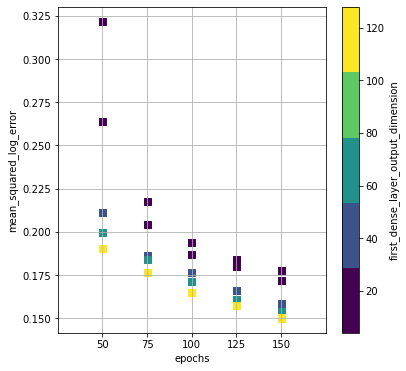

In [23]:
ncolors = all_scores.first_dense_layer_output_dimension.nunique()


fig, ax = plt.subplots()
all_scores.plot.scatter(x='epochs', y='mean_squared_log_error', 
                      c='first_dense_layer_output_dimension',
                      figsize=(6,6), 
                      ax=ax,
                      cmap=plt.cm.get_cmap('viridis', ncolors), s=50, marker='s')
_ = ax.grid(True)
_ = ax.set_xlim([25, 175])
_ = ax.set_xticks(epochs_list)
_ = ax.set_xticklabels([str(x) for x in epochs_list])


There were 0 negative predictions
1-step MSLE [Naive, CNN model] = [0.12127598504241711,0.10106225614271366]
1-step R^2 [Naive, CNN model] = [0.91597417503742,0.925674762108845]


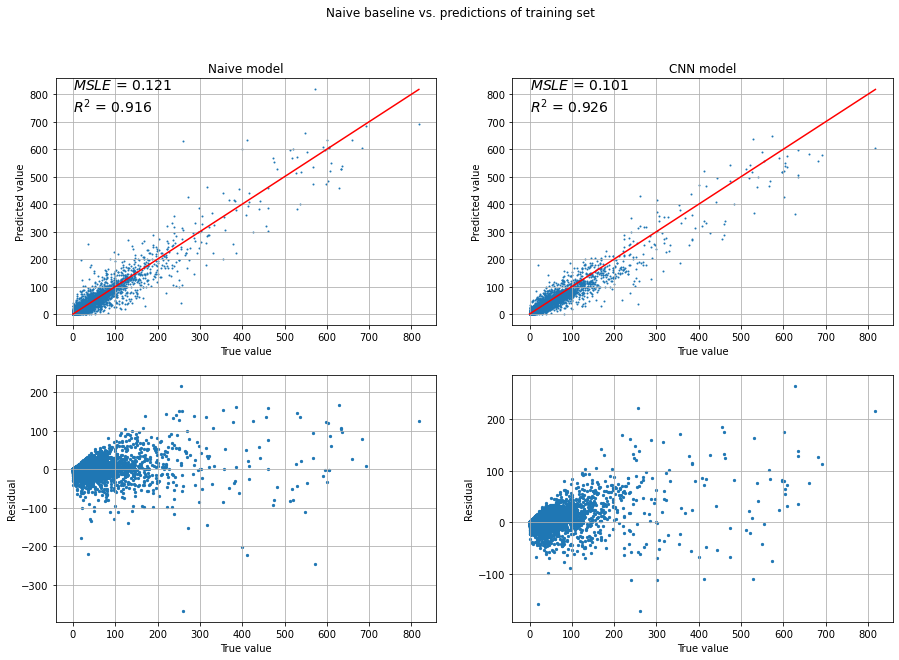

In [30]:
y_true = y_final_train.ravel()
y_predict = best_cnn.predict(X_final_train).ravel()
y_naive = np.concatenate((y_train_naive, y_validate_naive),axis=0)
model_analysis(y_true, y_naive, y_predict, n_countries, title='CNN model',
               suptitle='Naive baseline vs. predictions of training set', s=1,
              figname='cnn_train_performance.jpg')

Next perform a final evaluation on the holdout set, data which is completely unknown to the model. 

There were 0 negative predictions
1-step MSLE [Naive, CNN model] = [0.1765525676461385,0.12254891863560782]
1-step R^2 [Naive, CNN model] = [0.8302251301912098,0.9411902580180408]


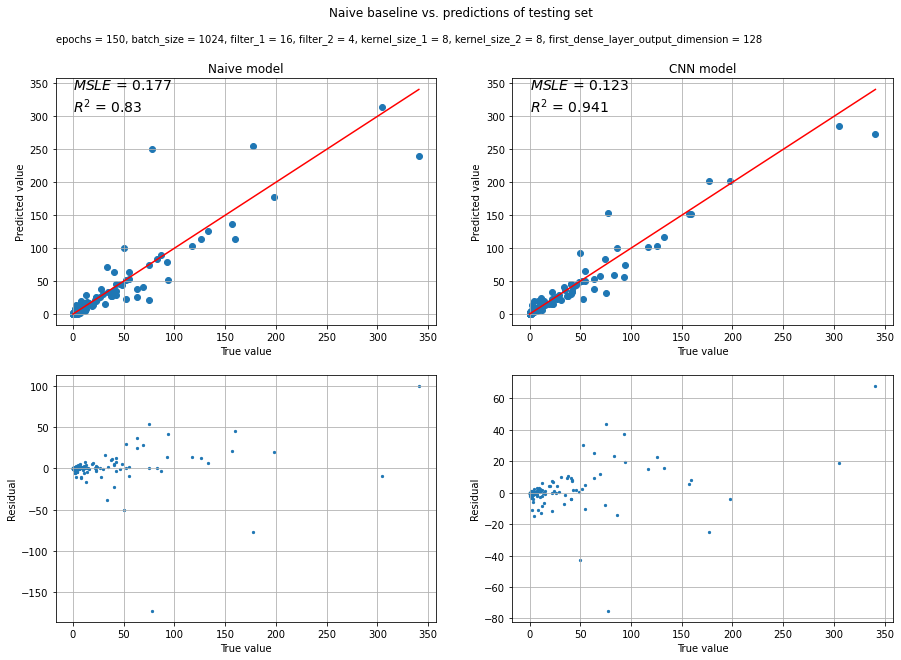

In [33]:
y_true = y_cnn_test_model.ravel()
y_predict = best_cnn.predict(X_cnn_test_model).ravel()
y_naive = y_test_naive
model_analysis(y_true, y_naive, y_predict, n_countries, title='CNN model',
               suptitle='Naive baseline vs. predictions of testing set',
              figname='cnn_test_performance.jpg', model_params=best_model_parameters)

<a id='conclusion'></a>
# 5. Conclusion and Future Work
[Return to table of contents](#toc)

I would like to test whether or not removing some of the less "helpful" data would train the CNN more accurately. I.e. take the subset of the data where all countries have at least a single presenting case; this can be sliced by the conditional statement "data.days_since_first_case >= 1". Alternatively, I coulud simply truncate all time series but a certain cutoff date. This would be more uniform and hopefully have the same effect. Because the number

In [27]:
r = Ridge()
_ = r.fit(all_scores.iloc[:,:7],all_scores.iloc[:,8])

In [28]:
r.coef_

array([0.00057428, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00028933])

Even though originally I thought that including too many parameters would negatively affect performance, the opposite appears to be true. Because of the large batch size it's not obvious how many epochs to train on. The higher the dimension is, the longer it would take to overtrain (at least that is my intuition). We can see when overtraining starts to occur by seeing when the validation loss (mean squared error) no longer uniformly decreases with respect to parameter dimension. 

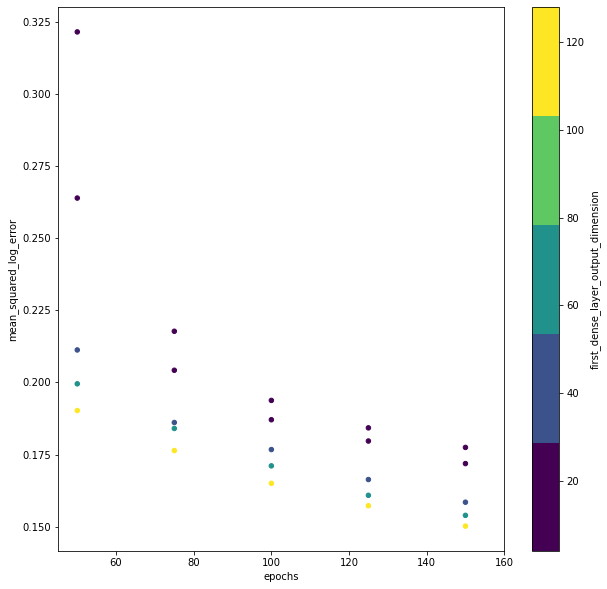

In [29]:
ncolors = all_scores.first_dense_layer_output_dimension.nunique()


fig, ax = plt.subplots()
cax = all_scores.plot.scatter(x='epochs', y='mean_squared_log_error', 
                      c='first_dense_layer_output_dimension',
                      figsize=(10,10), 
                      ax=ax,
                      cmap=plt.cm.get_cmap('viridis', ncolors))
loc,lab = plt.xticks()
_ = ax.set_xticks([int(l) for l in loc[1:]])
_ = ax.set_xticklabels([int(l) for l in loc[1:]])